# RNA - Atividade 2.1 - Perceptron de Rosenblatt

Neste projeto prático, o objetivo é implementar o algoritmo de treinamento mediante Aprendizado Supervisionado do neurônio Perceptron de Rosenblatt aplicado em problemas de classificação. Para tanto, cada equipe deverá elaborar Jupyter Notebooks com o código-fonte deste algoritmo de treinamento desenvolvido na linguagem de Programação Python e fazendo uso das bibliotecas numpy, random, math e matplotlib. Em particular, a biblioteca numpy será de uso obrigatório para todas as operações de natureza matricial (multiplicação de matrizes, produto escalar, etc). Neste projeto prático, a biblioteca sci-kit learn só deve ser utilizada para o cálculo de métricas de desempenho.

## Equipe

- Daniele Simas - 2015310060
- Felipe Amorim - 2115080033
- José Manuel - 2115080052
- Miguel Angelo - 2115080024

## Importação de Bibliotecas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Classe para controlar o treinamento do perceptron
from src.perceptron import Perceptron

# Funções auxiliares para carregar os arquivos do exercicio e encontrar o identificador da equipe
from src.utils import read_data, identifier

# Funções de ativação
from src.activation_functions import step_function

# Parte 1 - Resolvendo um problema linearmente separável

Nesta parte, todas as equipes devem usar o arquivo `dataAll.txt` e construir o algoritmo de treinamento do neurônio perceptron para resolver o problema de classificação proposto.

In [4]:
data = read_data('All')

print("Quantidade de pontos lidos:", len(data))
print("Formato dos dados:", data.shape)
print("\nExemplos de dados:", *[(x, y) for x,y in data[:5]], sep='\n')

Quantidade de pontos lidos: 1000
Formato dos dados: (1000, 2)

Exemplos de dados:
(array([-363.7884,  244.1423]), 0.0)
(array([ 328.7572, -256.7658]), 1.0)
(array([-164.9827,  613.2164]), 0.0)
(array([536.5905, 764.9575]), 0.0)
(array([314.2297, 343.8375]), 0.0)


1. As equipes devem utilizar a função de ativação degrau com ϑ = 0;
2. O valor da taxa de aprendizado deve ser igual a η = 0,1;
3. O vetor inicial de pesos deve ter seus valores inicializados conforme uma variável aleatória de distribuição uniforme no intervalo, isto é, wi ∼ U (−0,5, + 0,5). O vetor inicial de pesos deve ser impresso no início da execução do algoritmo;

In [18]:
perceptron = Perceptron(data=data, activation_function=step_function, bias=-1, learning_rate=0.1)

print('Vetor de pesos inicial: ', perceptron.weights)

perceptron.randomize_weights(floor=-0.5, ceiling=0.501)
print('Vetor de pesos após a randomização: ', perceptron.weights)

Vetor de pesos inicial:  [0. 0. 0.]
Vetor de pesos após a randomização:  [-0.14724458 -0.18929873 -0.39943084]


4. A cada época deve ser indicado o número de ajustes feitos no vetor de pesos;
5. O algoritmo deve executar até a convergência, isto é, até que não haja erros para todos os exemplos presentes no conjunto de treinamento;
6. Ao final, deve-se imprimir:
    - A - O número total de ajustes no vetor de pesos;
    - B - O número de épocas até a convergência;
    - C - O gráfico contendo todos os exemplos do conjunto de dados e a reta que separa as classes obtida como resultado do treinamento do neurônio Perceptron. Respeitar o esquema de cores proposto inicialmente e apresentar a solução de maneira clara neste gráfico.

In [19]:
epoch, updates = perceptron.train()

print('Treinamento finalizado!')
print('Quantidade de épocas até a convergência: ', epoch)
print('Quantidade de ajustes no vetor de pesos: ', updates)
print("Vetor de pesos final: ", perceptron.weights)
print("---")
print(*[f'Na epóca {index+1} foram realizados {count} ajustes.' for index, count in enumerate(perceptron.updates_per_epoch)], sep='\n')


Treinamento finalizado!
Quantidade de épocas até a convergência:  18
Quantidade de ajustes no vetor de pesos:  217
Vetor de pesos final:  [  -2.44724458  632.65251127 -631.04901084]
---
Na epóca 1 foram realizados 26 ajustes.
Na epóca 2 foram realizados 17 ajustes.
Na epóca 3 foram realizados 26 ajustes.
Na epóca 4 foram realizados 24 ajustes.
Na epóca 5 foram realizados 24 ajustes.
Na epóca 6 foram realizados 22 ajustes.
Na epóca 7 foram realizados 13 ajustes.
Na epóca 8 foram realizados 6 ajustes.
Na epóca 9 foram realizados 18 ajustes.
Na epóca 10 foram realizados 3 ajustes.
Na epóca 11 foram realizados 3 ajustes.
Na epóca 12 foram realizados 3 ajustes.
Na epóca 13 foram realizados 3 ajustes.
Na epóca 14 foram realizados 3 ajustes.
Na epóca 15 foram realizados 5 ajustes.
Na epóca 16 foram realizados 6 ajustes.
Na epóca 17 foram realizados 15 ajustes.
Na epóca 18 foram realizados 0 ajustes.


In [20]:
def plot_results(x_data, y_data, weights):
    plt.figure(figsize=(8,8))

    # Criar gráfico de dispersão dos pontos de entrada usando o parametro "data"
    class_0 = x_data[y_data == 0]
    class_1 = x_data[y_data == 1]

    plt.scatter(class_0[:, 1], class_0[:, 2], color='red', marker='x', label='Classe 0')

    plt.scatter(class_1[:, 1], class_1[:, 2], color='blue', marker='o', label='Classe 1')

    
    # Criar gráfico de linha da reta x2 = -(w1/w2)x1 + (w0/w2) gerada pelo perceptron
    w0, w1, w2 = weights

    x1_values = np.linspace(min(x_data[:, 1]) - 1, max(x_data[:, 1]) + 1, 2)
    x2_values = -(w1 / w2) * x1_values + (w0 / w2)
    
    plt.plot(x1_values, x2_values, color='black', linestyle='-', linewidth=2, label='Linha de decisão')

    # Adicionar títulos e legendas
    plt.title('Decision Boundary and Data Points')
    
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.legend()
    plt.grid(True)
    plt.show()

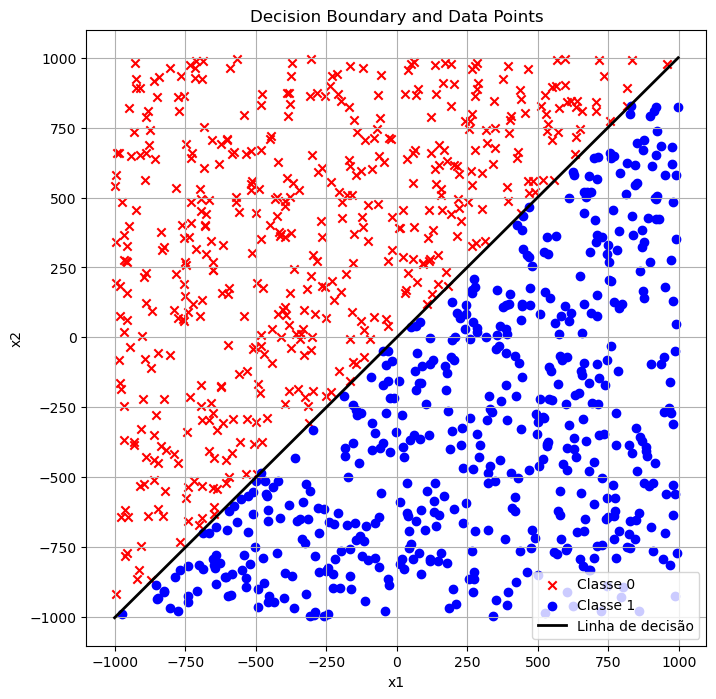

In [21]:
plot_results(perceptron.input_data, perceptron.output_data, perceptron.weights)

# Parte 2 - Experimentação

Nesta segunda parte, cada equipe deverá usar o seu respectivo identificador de exemplos para trabalhar com um arquivo específico.

In [ ]:
matriculas = ["2015310060", '2115080033', "2115080052", "2115080024"]

team_id = identifier(matriculas)

print("Identificador da equipe:", team_id)

data = read_data(team_id)

print("Quantidade de pontos lidos:", len(data))
print("Formato dos dados:", data.shape)
print("\nExemplos de dados:", *[(x, y) for x,y in data[:5]], sep='\n')

A equipe deve aproveitar o algoritmo construído na Parte 1 e executar 10 repetições do mesmo para as seguintes configurações: η × I = {0.4, 0.1, 0.01} × {(−100, + 100), (−0.5, + 0.5)} em que I é o intervalo a ser utilizado para a distribuição uniforme do valor dos pesos. Assim, há 6 configurações a serem testadas, cada uma delas por 10 repetições.

In [ ]:
def train_with_parameters(data, rates, ranges):
    perceptron = Perceptron(
        data=data,
        activation_function=step_function,
    )

    results = dict()
    for learning_rate in rates:
        perceptron.learning_rate = learning_rate

        for range_bounds in ranges:
            epochs_list = []
            updates_list = []

            min_epochs = float("inf")
            for train in range(10):
                # Init the perceptron with the learning_rate
                perceptron = Perceptron(
                    data=data,
                    activation_function=step_function,
                    bias=-1,
                    learning_rate=learning_rate,
                )

                # Draft the weights
                perceptron.randomize_weights(
                    floor=-range_bounds, ceiling=range_bounds + 0.1
                )

                # Train the perceptron
                epoch, updates = perceptron.train()

                # Save epochs and updates
                epochs_list.append(epoch)
                updates_list.append(updates)

                # Track the minimum number of epochs
                if epoch < min_epochs:
                    min_epochs = epoch

                if train == 9:
                    # TODO: plot the last solution
                    pass

            # Calculate mean and standard deviation
            mean_updates = np.mean(updates_list)
            std_updates = np.std(updates_list)

            # Save results in the dictionary
            results[(learning_rate, range_bounds)] = {
                "mean_updates": mean_updates,
                "std_updates": std_updates,
                "min_epochs": min_epochs,
            }

    return results

In [ ]:
rates = [0.4, 0.1, 0.01]
ranges = [100, 0.5]

results = train_with_parameters(data, rates=rates, ranges=ranges)

In [ ]:
table = PrettyTable()
table.field_names = [
    "Learning Rate",
    "Weight Range",
    "Mean Updates",
    "SD Updates",
    "Min Epochs",
]

# Add rows to the table
for key, value in results.items():
    learning_rate, range_val = key
    table.add_row(
        [
            learning_rate,
            f"{-range_val} to {range_val}",
            value["mean_updates"],
            value["std_updates"],
            value["min_epochs"],
        ]
    )

# Print the table
table

Para cada configuração, deve-se apresentar um único gráfico contendo as entradas e a solução obtida, para mostrar que todas as configurações, ainda que distintas, levam à convergência. O gráfico a ser mostrado pode conter a reta resultante da última repetição, por exemplo. É importante respeitar as sugestões de ilustração indicadas anteriormente.